In [11]:
import pandas as pd


columns_to_read = ["hrhhid", "hrhhid2", "peio1ocd", "ptdtrace", "hrhhid", "pulineno", "hrmonth", "gestfips", "pesex", "prtage", "peeduca", "peernlab"]
csv_files = ['../data/cpsb201801.csv', '../data/cpsb201804.csv', '../data/cpsb201808.csv', '../data/cpsb201812.csv', '../data/cpsb201901.csv', '../data/cpsb201904.csv', '../data/cpsb201908.csv', '../data/cpsb201912.csv']


dfs_18 = []
dfs_19 = []

for file in csv_files:
    if '2018' in file:
        df = pd.read_csv(file, usecols=columns_to_read)
        dfs_18.append(df)
    else: 
        df = pd.read_csv(file, usecols=columns_to_read)
        dfs_19.append(df)


combined_df_18 = pd.concat(dfs_18, ignore_index=True)
combined_df_19 = pd.concat(dfs_19, ignore_index=True)

#df.loc[df['city'] == 'New York', 'name']
combined_df_18.loc[combined_18_df['peio1ocd'] == '-1', 'pesex']

print(combined_df_18.head())
print(combined_df_19.head())



         hrhhid  hrmonth  hrhhid2  gestfips  prtage  pesex  peeduca  ptdtrace  \
0    4795110719        1     6011         1      71      1       42         1   
1    4795110719        1     6011         1      64      2       40         1   
2   71691004941        1     6111         1      72      1       40         1   
3   71691004941        1     6111         1      73      2       40         1   
4  110116792163        1     8011         1      66      1       43         1   

   pulineno  peernlab  peio1ocd  
0         1        -1        -1  
1         2        -1        -1  
2         1        -1      9140  
3         2        -1        -1  
4         1        -1      4920  
         hrhhid  hrmonth  hrhhid2  gestfips  prtage  pesex  peeduca  ptdtrace  \
0    4795110719        1     9011         1      68      1       38         2   
1    4795110719        1     9011         1      64      2       40         2   
2  110116792163        1     8011         1      -1     -1       -

In [29]:
sex = combined_df_18.loc[combined_df_18['peio1ocd'] == -1, 'pesex']
age = combined_df_18.loc[combined_df_18['peio1ocd'] == -1, 'prtage']

(array([128077.,  56355.,  18545.,  10203.,   8893.,   9370.,  14741.,
         25022.,  32572.,  26285.]),
 array([-1. ,  7.6, 16.2, 24.8, 33.4, 42. , 50.6, 59.2, 67.8, 76.4, 85. ]),
 <BarContainer object of 10 artists>)

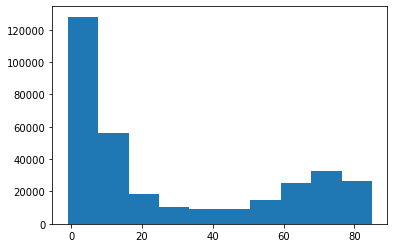

In [32]:
import matplotlib.pyplot as plt

#comparing the age distribution of the full sample and those who did not report an occupation. 
#They skew old and young which makes sense because they make up a solid portion of the unemployed population. 

plt.hist(combined_df_18['prtage'])
plt.hist(age)